In [109]:
from collections import Counter
from dataclasses import dataclass
from enum import Enum
from itertools import chain, combinations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from typing import Dict, List, Optional, Set, Tuple, Union

A state in the game consists of a `ScoreCard` (score card state), `RollValues` (values of dice showing on the table), and `rolls_completed` from 1 to 3 within the turn. The `ScoreCard` contains all needed information from the previous turns. The `RollValues` just contains the values of the five dice that have been rolled at a given point.

`GameState` contains all three of these objects. It provides `possible_score_actions`, which gives the scores possible with a given set of dice values and score card state. I frame these as actions because at any time the player can choose to end their turn and score with one of these values. For convenience, they are sorted in descending order by score. `GameState` also provides `possible_actions`, which includes roll actions in addition to the `possible_score_actions`. The `re_roll` method takes dice that are specified by value and rolls again. Finally, `GameState` provides an `update_score` method, which updates the scorecard given a choice of box.

The current score can be accessed at any time by calling the `score` method of the `GameState`'s `scorecard`.

In [2]:
class Box(Enum):
    Ones = "ones"
    Twos = "twos"
    Threes = "threes"
    Fours = "fours"
    Fives = "fives"
    Sixes = "sixes"
    ThreeOfAKind = "three_of_a_kind"
    FourOfAKind = "four_of_a_kind"
    FullHouse = "full_house"
    SmallStraight = "small_straight"
    LargeStraight = "large_straight"
    Yahtzee = "yahtzee"
    Chance = "chance"

In [3]:
class RollAction:
    def __init__(self, *dice_values_to_roll: int):
        if len(dice_values_to_roll) < 1:
            raise ValueError("You must roll at least one die.")
        if len(dice_values_to_roll) > 5:
            raise ValueError("You can roll at most five dice.")
        self.dice_values_to_roll = dice_values_to_roll

    def __repr__(self):
        return f"RollAction(dice_values_to_roll={self.dice_values_to_roll})"

@dataclass(frozen=True)
class ScoreAction:
    score: int
    dice_values: Tuple
    box: Box

In [4]:
class RollValues:
    def __init__(self, *values: int):
        if len(values) != 5:
            raise ValueError("There should be exactly five dice present.")
        if not set(values).issubset(set(range(1, 7))):
            raise ValueError("Die values must be integers from 1 to 6.")
        self.values = tuple(sorted(values))
        self.value_counts = dict(Counter(self.values))
    
    def __repr__(self):
        return f"Dice values = {', '.join([str(v) for v in self.values])}"
    
    def is_three_of_a_kind(self) -> bool:
        return any([v == 3 for v in self.value_counts.values()])
    
    def is_four_of_a_kind(self) -> bool:
        return any([v == 4 for v in self.value_counts.values()])
    
    def is_full_house(self) -> bool:
        return self.is_three_of_a_kind() and any([v == 2 for v in self.value_counts.values()])

    def is_small_straight(self) -> bool:
        values = set(self.values)
        return {1, 2, 3, 4}.issubset(values) or {2, 3, 4, 5}.issubset(values) or {3, 4, 5, 6}.issubset(values)
    
    def is_large_straight(self) -> bool:
        return tuple(sorted(set(self.values))) in {(1, 2, 3, 4, 5), (2, 3, 4, 5, 6)}
    
    def is_yahtzee(self) -> bool:
        return len(set(self.values)) == 1

    @property
    def score_actions(self) -> List[ScoreAction]:
        """
        Gives the possible score actions for a roll, acting as if the Score Card is empty.
        """
        results = []

        upper_boxes = [Box.Ones, Box.Twos, Box.Threes, Box.Fours, Box.Fives, Box.Sixes]
        for box, value in zip(upper_boxes, range(1, 7)):
            score = self.value_counts[value] * value if value in self.value_counts else 0
            dice_values = self.value_counts[value] * (value,) if value in self.value_counts else ()
            results.append(ScoreAction(score, dice_values, box))
        
        if self.is_three_of_a_kind():
            v = [v for v, c in self.value_counts.items() if c >= 3][0]
            score = 3 * v
            dice_values = 3 * (v,)
            box = Box.ThreeOfAKind
            results.append(ScoreAction(score, dice_values, box))
        else:
            results.append(ScoreAction(0, (), Box.ThreeOfAKind))
        
        if self.is_four_of_a_kind():
            v = [v for v, c in self.value_counts.items() if c >= 4][0]
            score = 4 * v
            dice_values = 4 * (v,)
            box = Box.FourOfAKind
            results.append(ScoreAction(score, dice_values, box))
        else:
            results.append(ScoreAction(0, (), Box.FourOfAKind))
        
        if self.is_full_house():
            score = 25
            dice_values = tuple(v for v in self.values)  # copy instead of reference (perhaps unnecessary)
            box = Box.FullHouse
            results.append(ScoreAction(score, dice_values, box))
        else:
            results.append(ScoreAction(0, (), Box.FullHouse))

        if self.is_small_straight():
            score = 30
            box = Box.SmallStraight
            if self.is_large_straight():
                dice_values = tuple(v for v in self.values)
            else:
                dice_values = tuple([s for s in [{1, 2, 3, 4}, {2, 3, 4, 5}, {3, 4, 5, 6}] if s.issubset(self.values)][0])
            results.append(ScoreAction(score, dice_values, box))
        else:
            results.append(ScoreAction(0, (), Box.SmallStraight))

        if self.is_large_straight():
            score = 40
            dice_values = tuple(v for v in self.values)
            box = Box.LargeStraight
            results.append(ScoreAction(score, dice_values, box))
        else:
            results.append(ScoreAction(0, (), Box.LargeStraight))

        if self.is_yahtzee():
            # For simplicity, ignore Yahtzee bonus and joker rules for now.
            # Later I will likely add that functionality at the GameState
            # level instead of here, since I'd prefer that the RollValues class 
            # not depend on ScoreCard. (I may change my mind on this.)
            v = self.values[0]
            score = 50
            dice_values = 5 * (v,)
            box = Box.Yahtzee
            results.append(ScoreAction(score, dice_values, box))
        else:
            results.append(ScoreAction(0, (), Box.Yahtzee))

        # Chance
        score = sum(self.values)
        dice_values = tuple(v for v in self.values)
        box = Box.Chance
        results.append(ScoreAction(score, dice_values, box))

        return results

In [78]:
class ScoreCard:
    def __init__(self):
        # For each string in the Box enum, make an attribute in this class
        self.ones: Optional[int] = None
        self.twos: Optional[int] = None
        self.threes: Optional[int] = None
        self.fours: Optional[int] = None
        self.fives: Optional[int] = None
        self.sixes: Optional[int] = None
        self.three_of_a_kind: Optional[int] = None
        self.four_of_a_kind: Optional[int] = None
        self.full_house: Optional[int] = None
        self.small_straight: Optional[int] = None
        self.large_straight: Optional[int] = None
        self.yahtzee: Optional[int] = None
        self.chance: Optional[int] = None
        # Maybe this should be in a test, but I'll put it here
        # for now (makes sure Box and the attributes above match)
        if set(vars(self).keys()) != {b.value for b in Box}:
            raise ValueError("Attributes of ScoreCard must match Box enum values.")
        
    def __repr__(self):
        return pd.DataFrame(self.all_scores_dict.items(), columns=["Category", "Value"]).to_string(index=False)

    @property
    def top_scores_dict(self) -> Dict[str, Optional[int]]:
        return {"ones": self.ones, "twos": self.twos, "threes": self.threes, "fours": self.fours, "fives": self.fives, "sixes": self.sixes}
    
    @property
    def bottom_scores_dict(self) -> Dict[str, Optional[int]]:
        return {"three_of_a_kind": self.three_of_a_kind, "four_of_a_kind": self.four_of_a_kind, "full_house": self.full_house, "small_straight": self.small_straight, "large_straight": self.large_straight, "yahtzee": self.yahtzee, "chance": self.chance}

    @property
    def all_scores_dict(self) -> Dict[str, Optional[int]]:
        return {**self.top_scores_dict, **self.bottom_scores_dict}
    
    @property
    def top_score(self) -> int:
        partial_sum = sum([s if s is not None else 0 for s in self.top_scores_dict.values()])
        return partial_sum + 35 if partial_sum >= 63 else partial_sum
    
    @property
    def bottom_score(self) -> int:
        return sum([s if s is not None else 0 for s in self.bottom_scores_dict.values()])
    
    @property 
    def score(self) -> int:
        return self.top_score + self.bottom_score
    
    @property
    def game_finished(self) -> bool:
        return all(self.all_scores_dict.values())

    @property 
    def unused_boxes(self) -> Set[Box]:
        return {b for b in Box if getattr(self, b.value) is None}
    
    def fill_in_box(self, box: Box, score: int):
        setattr(self, box.value, score)

In [6]:
def roll_first() -> RollValues:
    return RollValues(*random.choices(population=range(1, 7), k=5))

In [7]:
def roll_again(roll_values: RollValues, roll_action: RollAction) -> RollValues:
    if len(Counter(roll_action.dice_values_to_roll) - Counter(roll_values.values)) != 0:
        # It's not enough to do a subset check; consider the case where (1, 2, 3, 4, 5)
        # are the current values and (1, 1) are the (erroneous) values to re-roll.
        raise ValueError("You cannot re-roll dice that are not present.")
    values_that_stay = list((Counter(roll_values.values) - Counter(roll_action.dice_values_to_roll)).elements())
    new_values = random.choices(population=range(1, 7), k=len(roll_action.dice_values_to_roll))
    return RollValues(*(values_that_stay + new_values))

In [85]:
class GameState:
    def __init__(self, narrate: bool = True):
        self.narrate = narrate
        self.scorecard = ScoreCard()
        self.turn_started = False
    
    def start_turn(self):
        self.roll_values = roll_first()
        self.rolls_completed = 1
        if self.narrate:
            print(f"Roll number {self.rolls_completed} gives:")
            print(self.roll_values)
        self.turn_started = True
    
    @property
    def possible_score_actions(self) -> List[ScoreAction]:
        """
        Uses scorecard and roll_values to return the possible ScoreAction values.
        """
        return sorted([a for a in self.roll_values.score_actions if a.box in self.scorecard.unused_boxes], key=lambda x: x.score, reverse=True)

    @property
    def possible_roll_actions(self) -> List[RollAction]:
        """
        Uses scorecard and roll_values to return the possible RollAction values.
        Given how easy it is to determine RollAction values from a list of dice,
        this should be implemented in a way that requires less re-computation
        when we call possible_actions()... but for now I'll avoid premature optimization.
        """
        return [RollAction(*ps) for ps in chain.from_iterable([list(combinations(self.roll_values.values, i)) for i in range(1, 6)])]
    
    @property
    def possible_actions(self) -> List[Union[RollAction, ScoreAction]]:
        """
        Uses scorecard, roll_values, and rolls_completed to determine the possible actions, 
        which can be RollAction or ScoreAction values.
        """
        roll_actions = self.possible_roll_actions if self.rolls_completed < 3 else []
        return self.possible_score_actions + roll_actions
    
    def re_roll(self, *dice_values_to_roll: int):
        """
        Rolls the dice specified (by value) and updates roll_values and rolls_completed.
        """
        if not self.turn_started:
            raise ValueError("Please start your turn using the `start_turn()` method first.")
        roll_action = RollAction(*dice_values_to_roll)
        if self.rolls_completed >= 3:
            raise ValueError("Your three rolls for this turn have already been completed.")
        self.roll_values = roll_again(self.roll_values, roll_action)
        self.rolls_completed += 1
        if self.narrate:
            print(f"Roll number {self.rolls_completed} (re-rolling {', '.join([str(v) for v in dice_values_to_roll])}) gives:")
            print(self.roll_values)
    
    def update_score(self, box: Box):
        if not self.turn_started:
            raise ValueError("Please start your turn using the `start_turn()` method first.")
        # will need to update when I implement joker rules
        try:
            score = [a for a in self.possible_score_actions if a.box == box][0].score
        except IndexError:
            raise ValueError("You are trying to use a box that is already filled in.")
        self.scorecard.fill_in_box(box, score)
        self.turn_started = False
        if self.narrate:
            print(f"Filling in {box.name}, with value {score}\n")
    
    @property
    def best_scores(self, n: int = 3, print_only=True):
        if print_only:
            for a in self.possible_score_actions[:n]:
                print(a)
        else:
            return self.possible_score_actions[:n]
        
    def take_action(self, action: Union[ScoreAction, RollAction]):
        if isinstance(action, ScoreAction):
            self.update_score(action.box)
        elif isinstance(action, RollAction):
            self.re_roll(*action.dice_values_to_roll)
        else:
            raise ValueError("action must be an instance of `ScoreAction` or `RollAction`.")

In [92]:
class RandomAgent:
    """
    A completely random gameplay agent. At each timestep, it simply
    chooses one of the allowed actions, uniformly at random.
    It plays quite poorly, as often it chooses a `ScoreAction`
    with score 0 even when there are easy better options.
    """
    def __init__(self, narrate: bool = True):
        self.game_state = GameState(narrate=narrate)

        for _ in range(13):
            self.game_state.start_turn()
            while self.game_state.turn_started:
                action = random.choice(self.game_state.possible_actions)
                self.game_state.take_action(action)
        if narrate:
            print("Final scorecard:\n")
            print(self.game_state.scorecard, end="\n\n")
            print(f"Final score = {self.game_state.scorecard.score}")

In [93]:
random_agent = RandomAgent()

Roll number 1 gives:
Dice values = 1, 3, 4, 5, 6
Filling in Ones, with value 1

Roll number 1 gives:
Dice values = 1, 1, 1, 1, 2
Roll number 2 (re-rolling 1, 1, 1) gives:
Dice values = 1, 1, 2, 2, 3
Roll number 3 (re-rolling 2, 3) gives:
Dice values = 1, 1, 2, 5, 5
Filling in SmallStraight, with value 0

Roll number 1 gives:
Dice values = 1, 2, 2, 2, 2
Roll number 2 (re-rolling 2) gives:
Dice values = 1, 2, 2, 2, 6
Roll number 3 (re-rolling 1, 2, 2) gives:
Dice values = 2, 2, 2, 4, 6
Filling in Yahtzee, with value 0

Roll number 1 gives:
Dice values = 2, 2, 2, 5, 6
Filling in Twos, with value 6

Roll number 1 gives:
Dice values = 1, 1, 4, 5, 6
Roll number 2 (re-rolling 1, 5) gives:
Dice values = 1, 4, 6, 6, 6
Roll number 3 (re-rolling 1, 6) gives:
Dice values = 3, 3, 4, 6, 6
Filling in LargeStraight, with value 0

Roll number 1 gives:
Dice values = 2, 2, 3, 5, 6
Roll number 2 (re-rolling 2) gives:
Dice values = 2, 3, 5, 6, 6
Roll number 3 (re-rolling 2, 3, 5, 6, 6) gives:
Dice values =

In [104]:
random_agent_scores = []

for _ in range(10000):
    random_agent = RandomAgent(narrate=False)
    random_agent_scores.append(random_agent.game_state.scorecard.score)

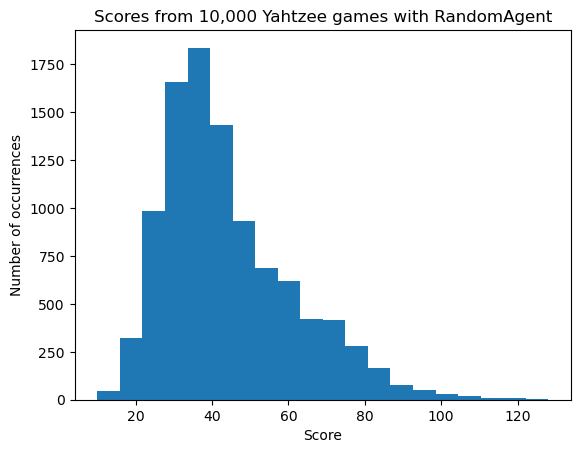

In [108]:
plt.hist(random_agent_scores, bins=20)
plt.xlabel("Score")
plt.ylabel("Number of occurrences")
plt.title("Scores from 10,000 Yahtzee games with RandomAgent")
plt.show()

In [113]:
print(f"Mean = {np.mean(random_agent_scores):.3g}")
print(f"Standard deviation = {np.std(random_agent_scores):.3g}")

Mean = 44.2
Standard deviation = 17.3


The mean score with 10,000 trials is less than 50 - that's pretty bad! There is a long tail on the right, with a few scores above 100 being achieved.

In this first pass at implementing the gameplay actions and scoring, I focused on development speed and cleanliness of the design. I deliberatly did not spend time optimizing for runtime speed, and it shows here, as it took almost 45 seconds to simulate 10,000 one-player games. I still think this is OK for now; I can optimize later once I start training some deep RL agents.